## Import libs

In [1]:
from __future__ import print_function, division, absolute_import
import os
import GPy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy import signal
import sys
sys.path.insert(0,'../..')
print(sys.path)
from mtfunc.helper import *
import safeopt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import tqdm
# plt.style.use('science')


['../..', '/Users/adrianpaeckelripoll/rbc-parameter-tuning/fig_scripts/optimizer_eval', '/opt/anaconda3/envs/env1/lib/python39.zip', '/opt/anaconda3/envs/env1/lib/python3.9', '/opt/anaconda3/envs/env1/lib/python3.9/lib-dynload', '', '/opt/anaconda3/envs/env1/lib/python3.9/site-packages', '/opt/anaconda3/envs/env1/lib/python3.9/site-packages/IPython/extensions', '/Users/adrianpaeckelripoll/.ipython']
/Users/adrianpaeckelripoll/rbc-parameter-tuning/mtfunc   was appended to PYTHONPATH


In [15]:

rnd_opt_cst=get_data('NL_opt/mrnd_opt_cst_winter_3_1_2_2022_03_13_1922.npy')
rnd_opt_par=get_data('NL_opt/mrnd_opt_par_winter_3_1_2_2022_03_13_1922.npy')


# Evaluation 

In [16]:
eval_df.loc[(0.5,'BO')].cnst_.shape

(31,)

False
False
beta: 0.5 par_num 1


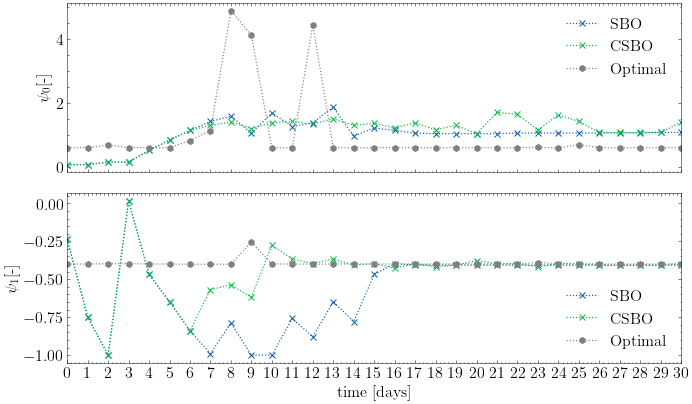

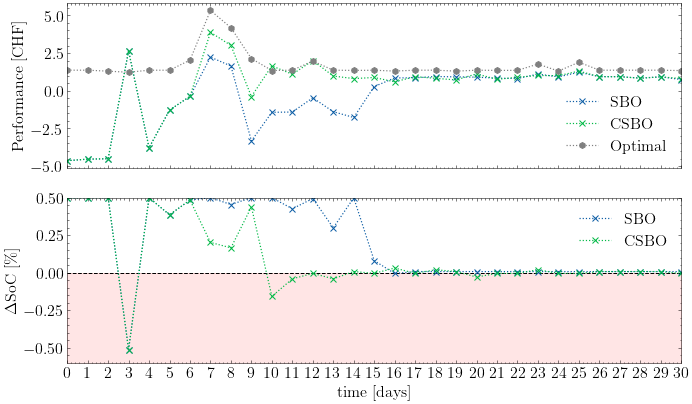

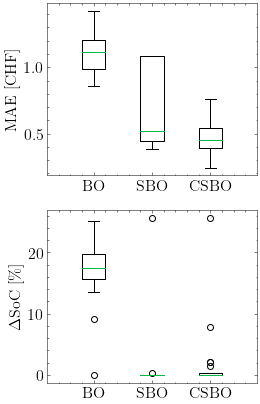

beta: 1 par_num 1


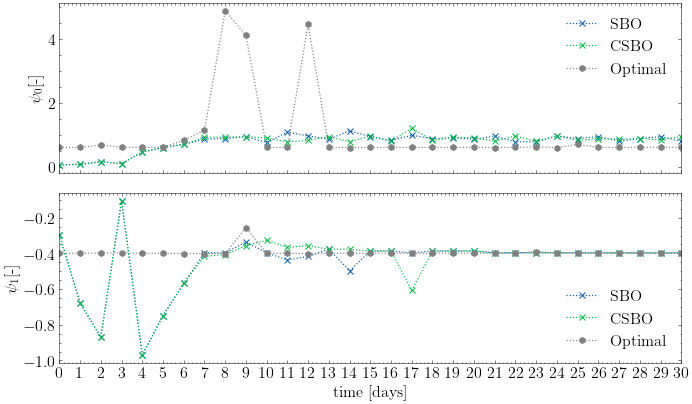

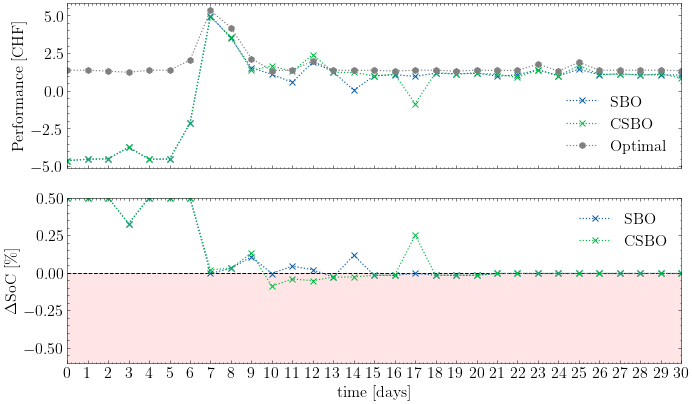

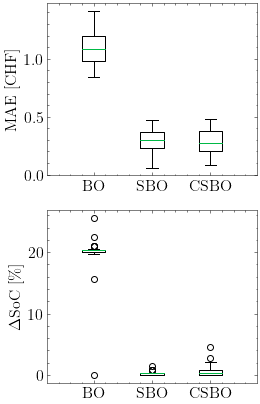

beta: 2 par_num 1


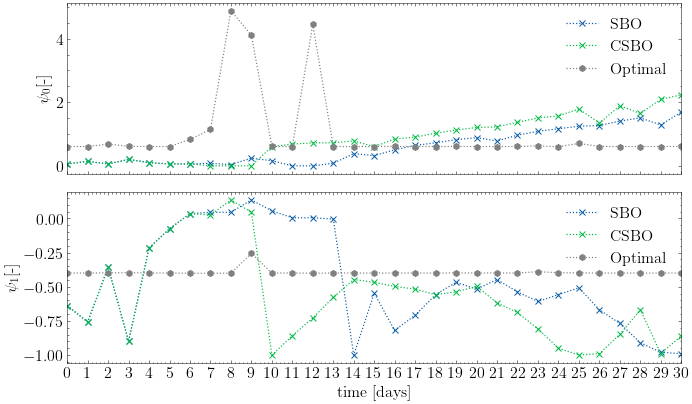

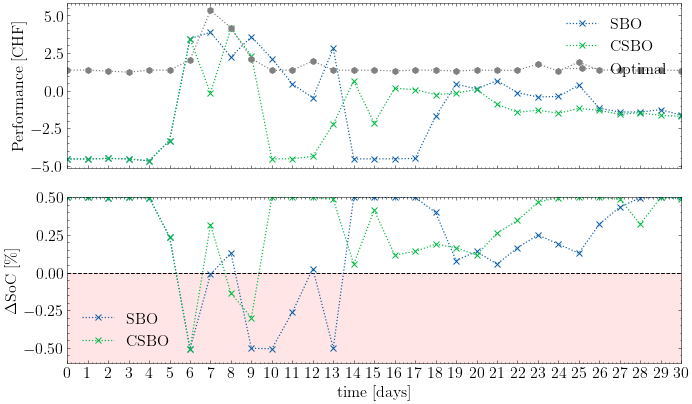

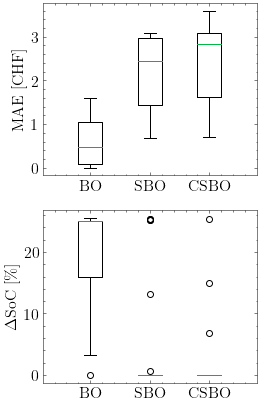

False
False
beta: 0.5 par_num 2


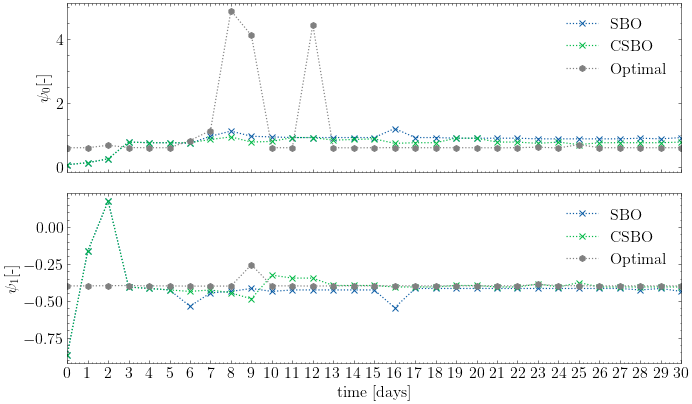

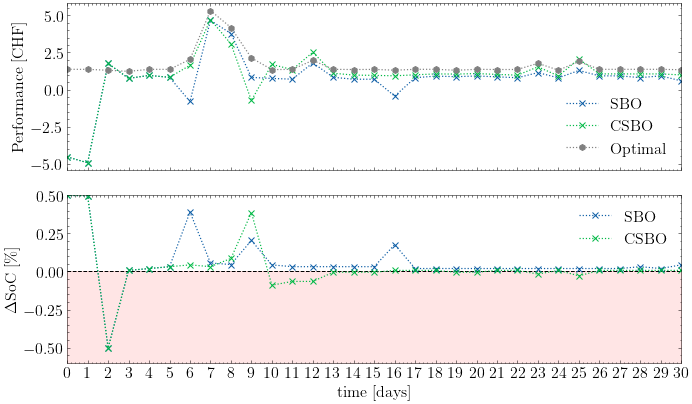

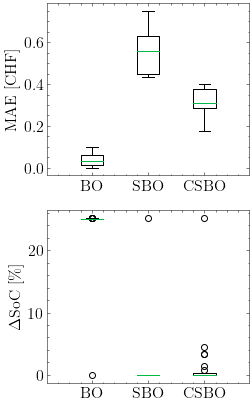

beta: 1 par_num 2


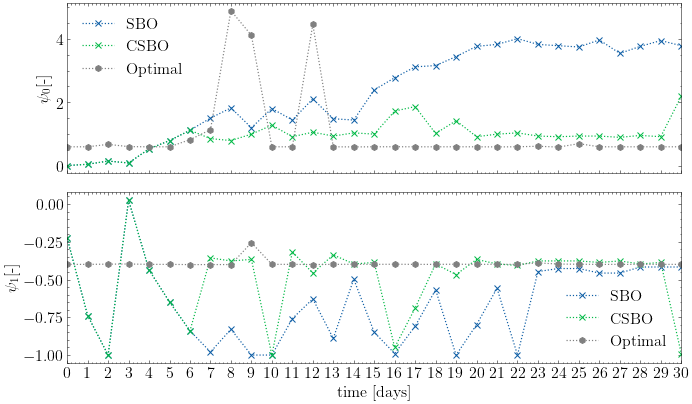

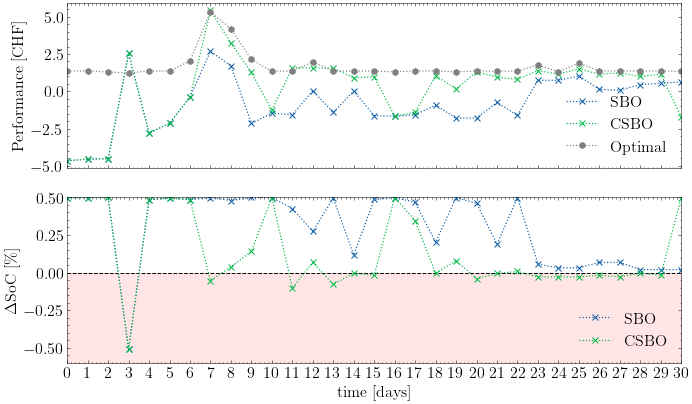

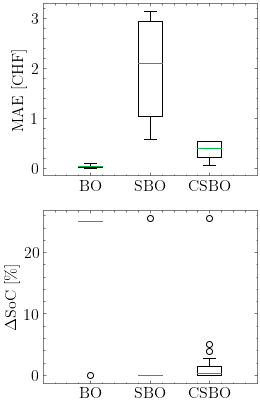

beta: 2 par_num 2


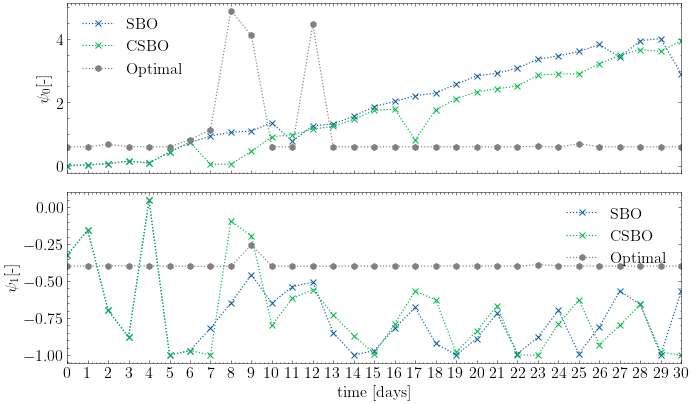

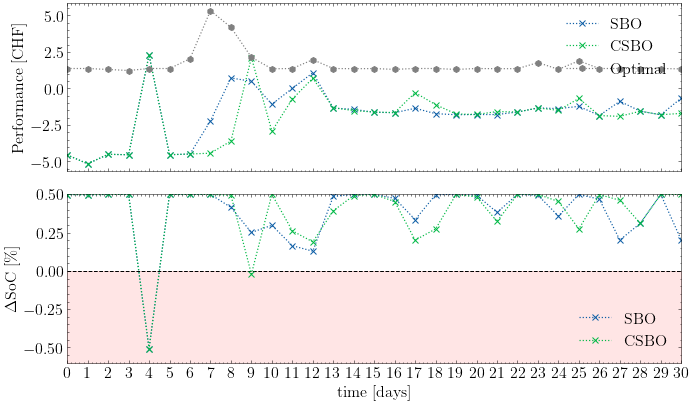

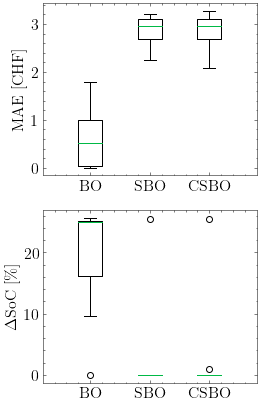

False
False
beta: 0.5 par_num 3


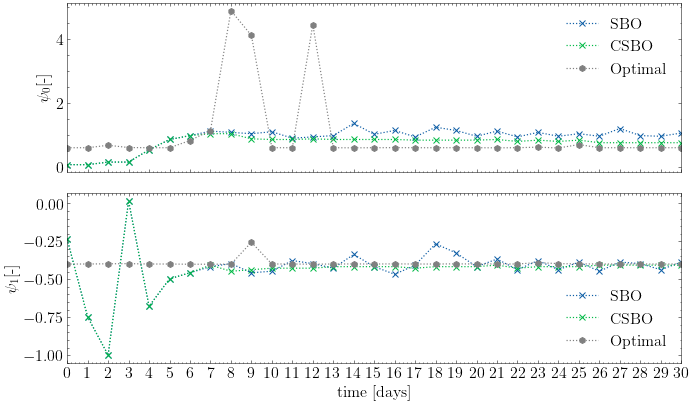

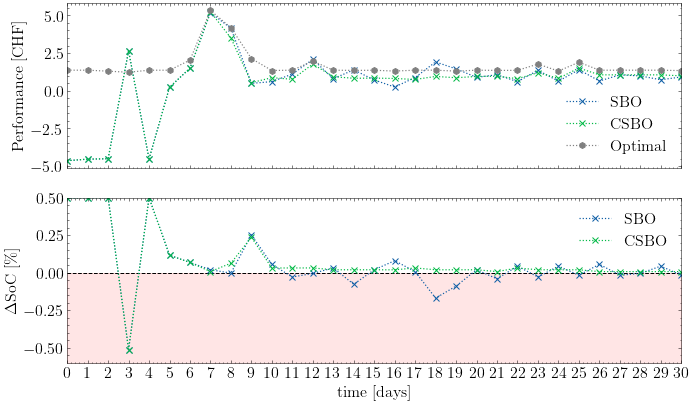

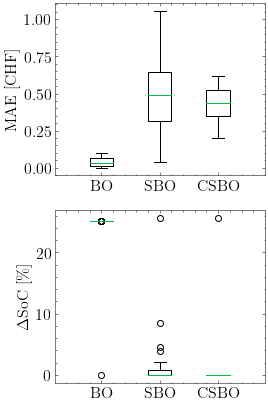

beta: 1 par_num 3


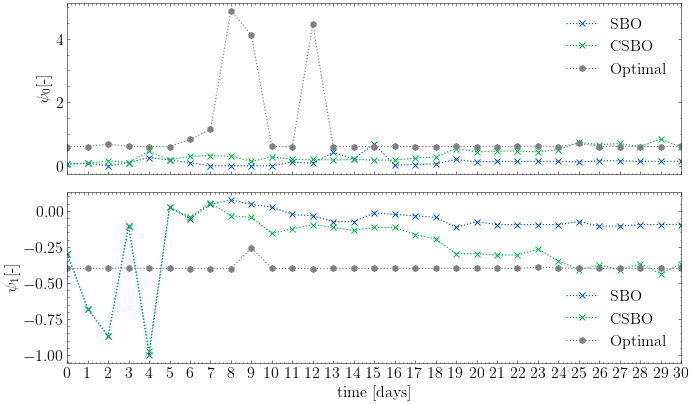

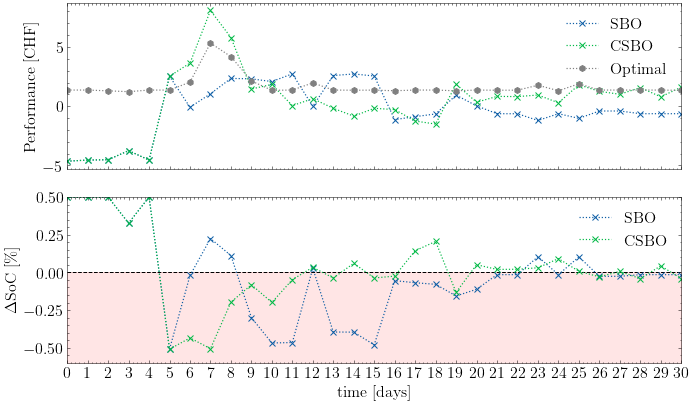

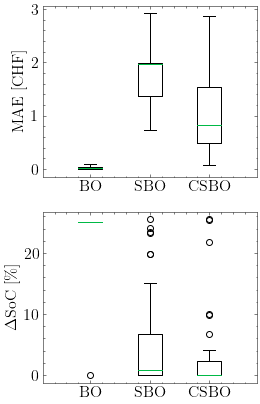

beta: 2 par_num 3


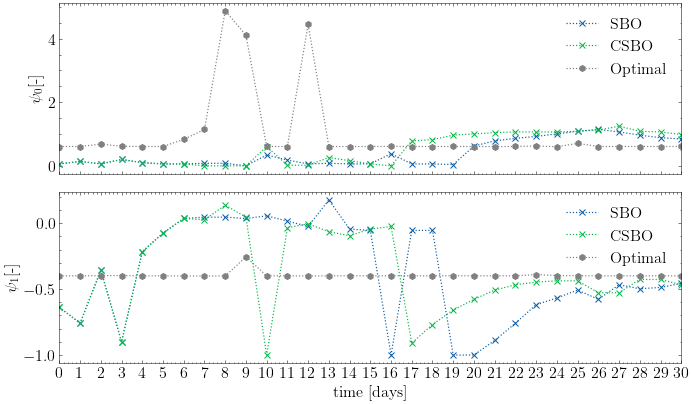

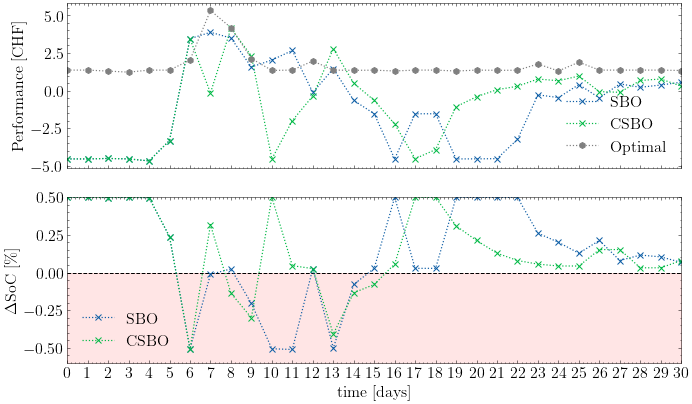

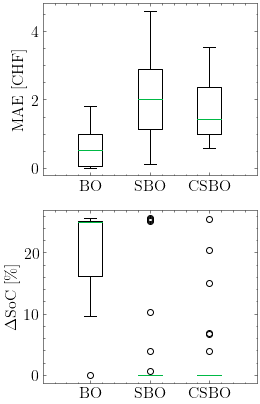

False
False
beta: 0.5 par_num 4


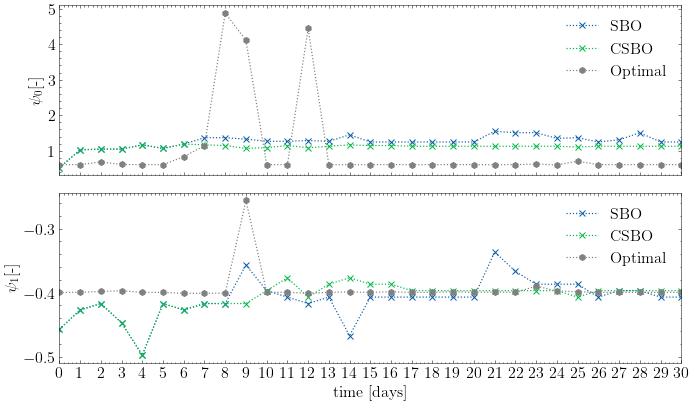

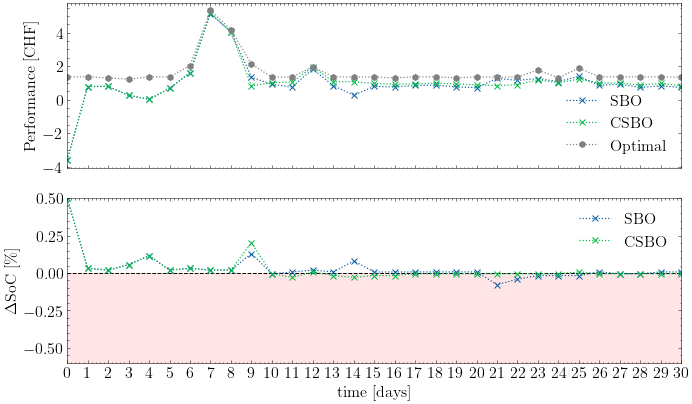

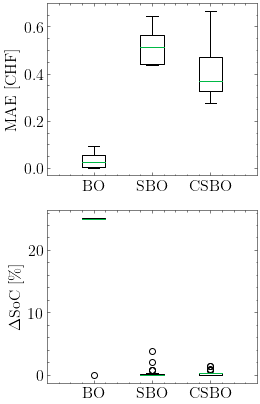

beta: 1 par_num 4


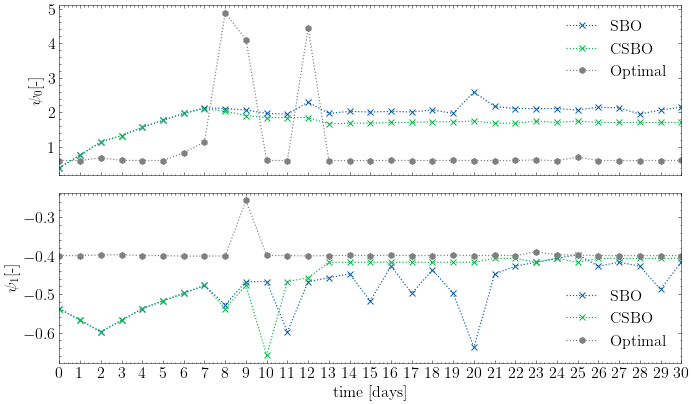

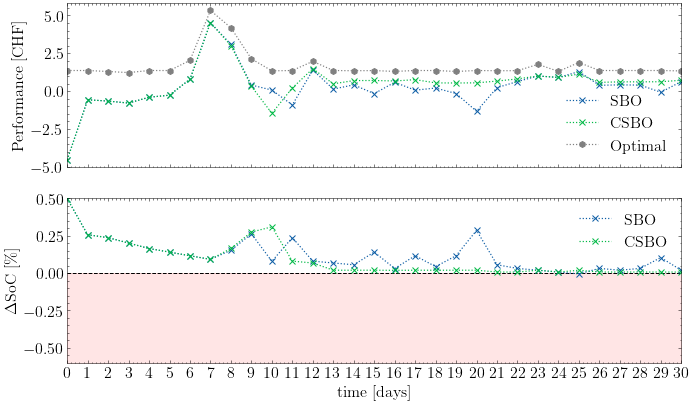

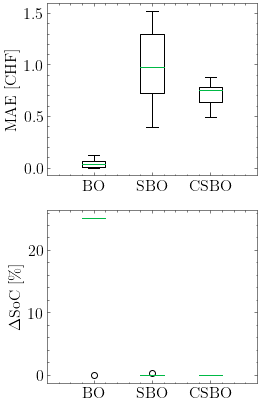

beta: 2 par_num 4


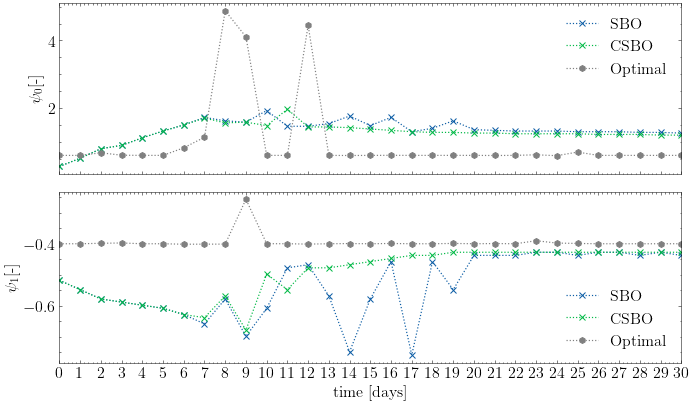

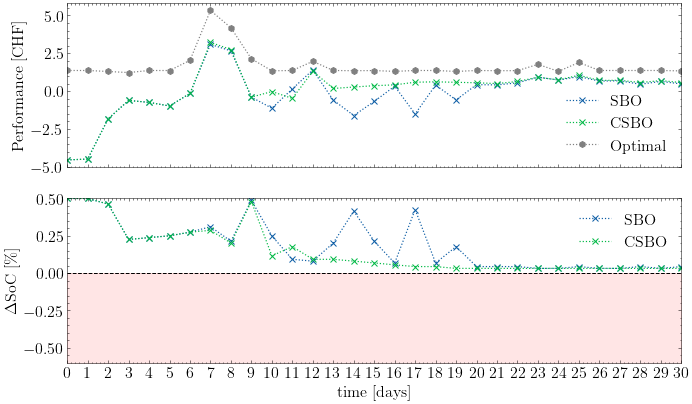

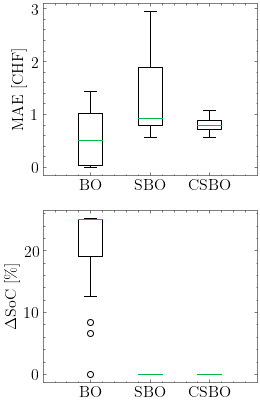

In [17]:
hp_list=[1,2,3,4]
xlim=30
for n in hp_list:
    import glob
    paths=glob.glob(f'sim_data_312_winter_rp0_qf_55_model/x_post_loglike{n}*')
    file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
    betas=[file_path.split('_')[3].strip('b') for file_path in file_paths] # get betas
    for i, beta in enumerate(betas):
        if beta.startswith('0'):
            betas[i]=float(beta.replace('0.','.'))
        else:
            betas[i]=float(beta) # convert to float and add . to 05

    optypes=[file_path.split('_')[4] for file_path in file_paths] # get optypes 
    dates=[file_path[-19:-4] for file_path in file_paths] # get betas

    par=[]
    for i,path in enumerate(paths):
        par.append(get_data(path))



    par_df=pd.DataFrame({'optype':optypes,'beta':betas,'par':par,'date':dates})
    par_df=par_df.set_index(['beta','optype']).sort_index()
    print(np.any(par_df.index.duplicated()))
    par_df=par_df[~par_df.index.duplicated()]

    paths=glob.glob(f'sim_data_312_winter_rp0_qf_55_model/y_post_loglike{n}*')
    file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
    betas=[file_path.split('_')[3].strip('b') for file_path in file_paths] # get betas
    for i, beta in enumerate(betas):
        if beta.startswith('0'):
            betas[i]=float(beta.replace('0.','.'))
        else:
            betas[i]=float(beta) # convert to float and add . to 05

    optypes=[file_path.split('_')[4] for file_path in file_paths] # get optypes 
    dates=[file_path[-19:-4] for file_path in file_paths] # get betas


    ct=10 #convergence time
    mae_=[]
    mae=[]
    cnst10=[]
    cnst0=[]
    cnst20=[]
    cnst15=[]
    cnst5=[]
    cts=[]
    cnst_hist=[]
    cnst_=[]
    cst_=[]
    for i,path in enumerate(paths):
        cst=get_data(path)[:]
        cst_.append(cst)
        err=-rnd_opt_cst.flatten()[ct:len(cst)]-cst[ct:,0]
        mae_.append(np.abs(err))
        mae.append(np.abs(err).sum()/(len(cst)-ct))
    #     err=-rnd_opt_cst.flatten()[:len(cst)]-cst[:]
    #     for j,e in enumerate(err):
    #         if (abs(e) <-rnd_opt_cst[j]*25e-2): break
    #     cts.append(j)    
        cnst=get_data(path)[:,1]
        cnst_hist.append(np.histogram(cnst,bins=20,range=(-0.5,0)))
        cnst10.append((cnst<-2e-2).astype(int).sum())
        cnst[cnst>0]=0
        cnst_.append(-cnst*50)


    eval_df=pd.DataFrame({'optype':optypes,'beta':betas,'cst_':cst_,'mae':mae,'mae_':mae_,'hst':cnst_hist,'date':dates,
                         'cnst10':cnst10,'cnst_':cnst_})
    eval_df=eval_df.set_index(['beta','optype']).sort_index()
    print(np.any(eval_df.index.duplicated()))
    eval_df=eval_df[~eval_df.index.duplicated()]
    betas_list=[0.5,1,2]
    for beta in betas_list:
        print('beta:',beta,'par_num',n)
        model_label=[ 'SBO','CSBO']
        height=6
        with plt.style.context('science'):
            err=25e-2
            plt.rcParams.update({'font.size': 16})            
            iterations=len(par_df.loc[(beta,'CSBO'),'par'][:,0])
            fig,ax=plt.subplots(2,sharex=True,figsize=(10,height))
            for col in model_label:
                ax[0].plot(range(iterations),par_df.loc[(beta,col),'par'][:,0],':x',label=col,linewidth=1.2)
                ax[1].plot(range(iterations),par_df.loc[(beta,col),'par'][:,1],':x',label=col,linewidth=1.2)
            ax[0].plot(range(iterations),rnd_opt_par[:iterations,0],':h',label='Optimal',linewidth=1.2,color='grey')
            ax[1].plot(range(iterations),rnd_opt_par[:iterations,1],':h',label='Optimal',linewidth=1.2,color='grey')
            ax[0].set_xticks(np.arange(0,iterations,1))
            ax[0].set_ylabel(r'$\psi_0$[-]')
            ax[0].legend()    
            ax[1].set_ylabel(r'$\psi_1$[-]')
            ax[1].legend()

            plt.xlabel('time [days]')
            plt.xlim([0,xlim])
            plt.subplots_adjust(hspace=0.02)
            plt.tight_layout()            
#             plt.savefig(f'Qf/{n}_par_rp_b0_qf_55_beta_{beta}.pdf')
            plt.show()
    
        with plt.style.context('science'):
            plt.rcParams.update({'font.size': 16})
            err=25e-2
            iterations=len(par_df.loc[(beta,'CSBO'),'par'][:,0])
            fig,ax=plt.subplots(2,sharex=True,figsize=(10,height))
            for col in model_label:
                ax[0].plot(range(iterations),eval_df.loc[(beta,col),'cst_'][:,0],':x',label=col,linewidth=1.2)
                ax[1].plot(range(iterations),eval_df.loc[(beta,col),'cst_'][:,1],':x',label=col,linewidth=1.2)
            ax[0].plot(range(iterations),-rnd_opt_cst[:iterations,0],':h',label='Optimal',linewidth=1.2,color='grey')
            ax[1].hlines(0,0,iterations,'k',linestyles='--')
            ax[1].fill_between(range(iterations),y1=0,y2=-1,color='red',alpha=0.1)
        #     ax[1].plot(range(iterations),rnd_opt_cst[:iterations,1],':h',label='Optimal',linewidth=1.2,color='grey')
            ax[0].set_xticks(np.arange(0,iterations,1))
            ax[1].set_ylim([-0.6,0.5])
            ax[0].set_ylabel(r'Performance [CHF]')
            ax[0].legend()    
            ax[1].set_ylabel(r'$\Delta$SoC [\%]')
            ax[1].legend()

            plt.xlabel('time [days]')
            plt.xlim([0,xlim])
            plt.subplots_adjust(hspace=0.02)
            plt.tight_layout()
#             plt.savefig(f'Qf/{n}_prf_rp_b0_qf_55_beta_{beta}.pdf')
            plt.show()
        model_label=['BO','SBO', 'CSBO']
        model_names=['BO', 'SBO', 'CSBO']
        with plt.style.context('science'):
            plt.rcParams.update({'font.size': 16})            
            plt.figure(figsize=(4,height))
            for i,col in enumerate(model_label): 
                plt.subplot(211,)
                plt.boxplot(eval_df.loc[(beta,col)].mae_,showfliers=False,showmeans=False,labels=[model_names[i]],positions=[i/4],widths=0.1)
                plt.ylabel(r'MAE [CHF]')
                plt.xlim([-0.2,0.7]) 
                plt.subplot(212)
                plt.boxplot(eval_df.loc[(beta,col)].cnst_,showfliers=True,showmeans=False,labels=[model_names[i]],positions=[i/4],widths=0.1)
                plt.ylabel(r'$\Delta$SoC [\%]')
#                 plt.ylim([-0.001,None])
    #             plt.yscale('log')
            #     plt.ylabel(r'$\textrm{R}^2$')
                plt.xlim([-0.2,0.7])   
    #         plt.locator_params(axis="y", nbins=5) 
    #         plt.margins(tight=True)  
        #     plt.legend(['beta'])
            plt.tight_layout()
#             plt.savefig(f'Qf/{n}_model_mae_qf_boxplot_beta_{beta}.pdf')
            plt.show()

In [ ]:
hp_list=[1,2,3,4]
xlim=30
for n in hp_list:
    import glob
    paths=glob.glob(f'sim_data_312_winter_rp0_qf_55_model/x_post_loglike{n}*')
    file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
    betas=[file_path.split('_')[3].strip('b') for file_path in file_paths] # get betas
    for i, beta in enumerate(betas):
        if beta.startswith('0'):
            betas[i]=float(beta.replace('0.','.'))
        else:
            betas[i]=float(beta) # convert to float and add . to 05

    optypes=[file_path.split('_')[4] for file_path in file_paths] # get optypes 
    dates=[file_path[-19:-4] for file_path in file_paths] # get betas

    par=[]
    for i,path in enumerate(paths):
        par.append(get_data(path))



    par_df=pd.DataFrame({'optype':optypes,'beta':betas,'par':par,'date':dates})
    par_df=par_df.set_index(['beta','optype']).sort_index()
    print(np.any(par_df.index.duplicated()))
    par_df=par_df[~par_df.index.duplicated()]

    paths=glob.glob(f'sim_data_312_winter_rp0_qf_55_model/y_post_loglike{n}*')
    file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
    betas=[file_path.split('_')[3].strip('b') for file_path in file_paths] # get betas
    for i, beta in enumerate(betas):
        if beta.startswith('0'):
            betas[i]=float(beta.replace('0.','.'))
        else:
            betas[i]=float(beta) # convert to float and add . to 05

    optypes=[file_path.split('_')[4] for file_path in file_paths] # get optypes 
    dates=[file_path[-19:-4] for file_path in file_paths] # get betas


    ct=10 #convergence time
    mae_=[]
    mae=[]
    cnst10=[]
    cnst0=[]
    cnst20=[]
    cnst15=[]
    cnst5=[]
    cts=[]
    cnst_hist=[]
    cnst_=[]
    cst_=[]
    for i,path in enumerate(paths):
        cst=get_data(path)[:]
        cst_.append(cst)
        err=-rnd_opt_cst.flatten()[ct:len(cst)]-cst[ct:,0]
        mae_.append(np.abs(err))
        mae.append(np.abs(err).sum()/(len(cst)-ct))
    #     err=-rnd_opt_cst.flatten()[:len(cst)]-cst[:]
    #     for j,e in enumerate(err):
    #         if (abs(e) <-rnd_opt_cst[j]*25e-2): break
    #     cts.append(j)    
        cnst=get_data(path)[:,1]
        cnst_hist.append(np.histogram(cnst,bins=20,range=(-0.5,0)))
        cnst10.append((cnst<-2e-2).astype(int).sum())
        cnst[cnst>0]=0
        cnst_.append(-cnst*50)


    eval_df=pd.DataFrame({'optype':optypes,'beta':betas,'cst_':cst_,'mae':mae,'mae_':mae_,'hst':cnst_hist,'date':dates,
                         'cnst10':cnst10,'cnst_':cnst_})
    eval_df=eval_df.set_index(['beta','optype']).sort_index()
    print(np.any(eval_df.index.duplicated()))
    eval_df=eval_df[~eval_df.index.duplicated()]

In [28]:
hp_list=[1,2,3,4,5]
tlim=50
height=8
height2=6

import glob
paths=glob.glob(f'sim_data_312_winter_rp0_qf_55_model/x_post_*')
file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
betas=[file_path.split('_')[3].strip('b') for file_path in file_paths] # get betas
for i, beta in enumerate(betas):
    if beta.startswith('0.'):
        betas[i]=float(beta.replace('0.','.'))
    elif beta.startswith('0'):
        betas[i]=float(beta.replace('0','.'))       
    else:
        betas[i]=float(beta) # convert to float and add . to 05

optypes=[file_path.split('_')[4] for file_path in file_paths] # get optypes 
dates=[file_path[-19:-4] for file_path in file_paths] # get betas

par=[]
for i,path in enumerate(paths):
    par.append(get_data(path))



par_df=pd.DataFrame({'optype':optypes,'beta':betas,'par':par,'date':dates})
par_df=par_df.set_index(['beta','optype']).sort_index()
print(np.any(par_df.index.duplicated()))
# par_df=par_df[~par_df.index.duplicated()]

paths=glob.glob(f'sim_data_312_winter_rp0_qf_55_model/y_post*')
file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
betas=[file_path.split('_')[3].strip('b') for file_path in file_paths] # get betas
hpar=[file_path.split('_')[2].strip('b') for file_path in file_paths] # get hp names
for i, beta in enumerate(betas):
    if beta.startswith('0.'):
        betas[i]=float(beta.replace('0.','.'))
    elif beta.startswith('0'):
        betas[i]=float(beta.replace('0','.'))        
    else:
        betas[i]=float(beta) # convert to float and add . to 05

optypes=[file_path.split('_')[4] for file_path in file_paths] # get optypes 
dates=[file_path[-19:-4] for file_path in file_paths] # get betas
ct=10 #convergence time
mae_=[]
mae=[]
cnst10=[]
cnstavg=[]
sftavg=[]
cts=[]
cnst_hist=[]
cnst_=[]
sft_=[]
cst_=[]
for i,path in enumerate(paths):
    cst=get_data(path)[:]
    cst_.append(cst)
    err=-rnd_opt_cst.flatten()[ct:len(cst)]-cst[ct:,0]
    mae_.append(np.abs(err))
    mae.append(np.abs(err).mean())
    cnst=get_data(path)[:,1]
#     sft=get_data(path)[:,2]        
    cnst_hist.append(np.histogram(cnst,bins=20,range=(-0.5,0)))
    cnst10.append((cnst<-2e-2).astype(int).sum())
    cnst[cnst>0]=0
    cnst_.append(-cnst*50)
    cnstavg.append(cnst.mean()*50)
#     sft[sft>0]=0
#     sft_.append(-sft*50) 
#     sftavg.append(sft.mean()*50)


eval_df=pd.DataFrame({'optype':optypes,'beta':betas,'mae':mae,'cnst':cnstavg,'cst_':cst_,'mae_':mae_,'hst':cnst_hist,'date':dates,
                     'cnst10':cnst10,'cnst_':cnst_,'hpar':hpar})
eval_df=eval_df.set_index(['beta','optype']).sort_index()
print(np.any(eval_df.index.duplicated()))
# eval_df=eval_df[~eval_df.index.duplicated()]


True
True


In [29]:
eval_df.sort_values('mae')

mae       cnst  \
beta optype                        
1.0  BO      0.110716 -24.245505   
     BO      0.110716 -24.245505   
0.5  BO      0.111399 -24.247865   
     BO      0.114839 -24.257684   
     BO      0.114839 -24.257684   
1.0  BO      0.115017 -24.256196   
0.5  CSBO    0.317605  -1.282015   
1.0  SBO     0.351778  -0.291037   
     CSBO    0.366995  -0.611991   
0.5  CSBO    0.391075  -0.287106   
     CSBO    0.433191  -0.825249   
     CSBO    0.458041  -1.321747   
     SBO     0.483672  -1.631505   
     SBO     0.489338  -0.297548   
2.0  BO      0.561739 -20.267530   
     BO      0.561739 -20.267530   
     BO      0.586331 -21.458004   
0.5  SBO     0.589549  -0.810659   
2.0  BO      0.592445 -19.938408   
1.0  CSBO    0.810958   0.000000   
     CSBO    0.826718  -1.567747   
2.0  CSBO    0.877405   0.000000   
1.0  CSBO    1.026823  -3.747107   
0.5  SBO     1.065092  -0.834016   
     BO      1.105398 -17.280286   
1.0  BO      1.129069 -19.772313   
     SBO     1.129728  -0.008228   
2.0  SBO     1.275618   0.000000   
1.0  SBO     1.787764  -5.891635   
     SBO     1.987329  -0.823473   
2.0  CSBO    2.136558  -2.530675   
0.5  SBOb    2.390265  -0.820694   
     SBOb    2.559794  -0.743821   
2.0  SBO     2.568397  -3.752059   
     SBO     2.647970  -3.705910   
1.0  SBOb    2.654160  -1.496423   
2.0  SBO     2.704099  -0.819161   
0.5  SBOb    2.715372  -1.360151   
2.0  CSBO    2.833156  -0.852634   
1.0  SBOb    2.851669  -0.503535   
     SBOb    2.857530  -0.513366   
2.0  CSBO    2.918147  -1.526596   
0.5  SBOb    2.968837  -1.164009   
2.0  SBOb    3.092608  -0.816221   
     SBOb    3.177343  -0.701490   
1.0  SBOb    3.438115   0.000000   
2.0  SBOb    3.465252  -0.539347   
     SBOb    3.975933   0.000000   

                                                          cst_  \
beta optype                                                      
1.0  BO      [[-1.9735311822432902, 0.4993124462134446], [1...   
     BO      [[-1.9735311822432902, 0.4993124462134446], [1...   
0.5  BO      [[-1.9628737928844862, 0.4993123681134861], [1...   
     BO      [[-1.973535657233227, 0.4993124524395051], [1....   
     BO      [[-1.973535657233227, 0.4993124524395051], [1....   
1.0  BO      [[-1.9521919327661426, 0.49931236000508616], [...   
0.5  CSBO    [[-4.542222306200333, 0.49945269260532343], [-...   
1.0  SBO     [[-4.637445308901041, 0.4983776592468817], [-4...   
     CSBO    [[-4.637445308901041, 0.4983776592468817], [-4...   
0.5  CSBO    [[-3.602694253682091, 0.49889238859906443], [0...   
     CSBO    [[-4.644915281185373, 0.4979522426175052], [-4...   
     CSBO    [[-4.644915281185373, 0.4979522426175052], [-4...   
     SBO     [[-4.644915281185373, 0.4979522426175052], [-4...   
     SBO     [[-3.602694253682091, 0.49889238859906443], [0...   
2.0  BO      [[-1.9735220094517745, 0.49931243336597675], [...   
     BO      [[-1.9735220094517745, 0.49931243336597675], [...   
     BO      [[-1.9181561894491228, 0.49931234319851314], [...   
0.5  SBO     [[-4.542222306200333, 0.49945269260532343], [-...   
2.0  BO      [[-1.6861644928142185, 0.4993121450299873], [2...   
1.0  CSBO    [[-4.5320537834012615, 0.4991120844423125], [-...   
     CSBO    [[-4.659192294246759, 0.49786153383114196], [-...   
2.0  CSBO    [[-4.539075160930448, 0.49907728240448224], [-...   
1.0  CSBO    [[-4.637445308901041, 0.4983776592468817], [-4...   
0.5  SBO     [[-4.644915281185373, 0.4979522426175052], [-4...   
     BO      [[-1.7176412606071958, 0.49931218539874067], [...   
1.0  BO      [[-1.7069682478527506, 0.49931217234724956], [...   
     SBO     [[-4.5320537834012615, 0.4991120844423125], [-...   
2.0  SBO     [[-4.539075160930448, 0.49907728240448224], [-...   
1.0  SBO     [[-4.637445308901041, 0.4983776592468817], [-4...   
     SBO     [[-4.659192294246759, 0.49786153383114196], [-...   
2.0  CSBO    [[-4.542364839002397, 0.4992529666803898], [-4...   
0.5  SBOb    [[-4.644915281185373, 0.49

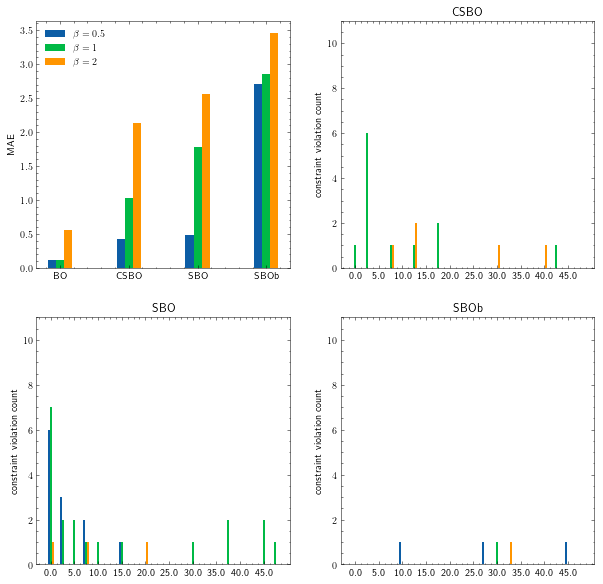

In [149]:
with plt.style.context('science'):
    x = np.arange(len(eval_df.index.levels[1]))  # the label locations
    width = 0.35  # the width of the bars

    fig, axes = plt.subplots(2,2,figsize=(10,10))
    rects1 = axes[0,0].bar(x - width/3, eval_df.loc[0.5].mae, width/3, label=r'$\beta=0.5$')
    rects2 = axes[0,0].bar(x , eval_df.loc[1].mae, width/3, label=r'$\beta=1$',tick_label=eval_df.index.levels[1])
    rects3 = axes[0,0].bar(x + width/3, eval_df.loc[2].mae, width/3, label=r'$\beta=2$')
    axes[0,0].set_ylabel('MAE')
    axes[0,0].legend()
    n_bins=20
    x = np.arange(len(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:]))  # the label locations
    for i,ax in enumerate(axes.flatten()[1:]):
        width=0.5
        op=eval_df.index.levels[1][i+1]
        rects1 = ax.bar(x - width/3, eval_df.loc[(0.5,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=0.5$')
        rects2 = ax.bar(x , eval_df.loc[(1,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=1$',
                        tick_label=(np.abs(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:])*100).round(1)[::-1])
        rects3 = ax.bar(x + width/3, eval_df.loc[(2,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=2$')
        ax.set_xticks(np.arange(0,n_bins,2))
        
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('constraint violation count')
        ax.set_ylim([0,11])
        ax.set_title(op)
    # ax.bar_label(rects1, padding=3)
    # ax.bar_label(rects2, padding=3)
    # ax.bar_label(rects3, padding=3)

#     fig.tight_layout()
#     axes[1,1].set_xlim([10,30])
# plt.savefig('../fig_scripts/eval_mae_cnstviol_rp_qf55_loglike3_.png')
plt.show()

In [ ]:
with plt.style.context('science'):
    x = np.arange(len(eval_df.index.levels[1]))  # the label locations
    width = 0.35  # the width of the bars

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    rects1 = axes[0].bar(x - width/3, eval_df.loc[0.5].mae, width/3, label=r'$\beta=0.5$')
    rects2 = axes[0].bar(x , eval_df.loc[1].mae, width/3, label=r'$\beta=1$',tick_label=eval_df.index.levels[1])
    rects3 = axes[0].bar(x + width/3, eval_df.loc[2].mae, width/3, label=r'$\beta=2$')
    axes[0].set_ylabel('MAE')
    axes[0].legend()
    axes[0].set_xlabel('optimizer')

    n_bins=10
    x = np.arange(len(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:]))  # the label locations
    for i,ax in enumerate(axes.flatten()[1:]):
        width=0.5
        op=eval_df.index.levels[1][i+1]
        rects1 = ax.bar(x - width/3, eval_df.loc[(0.5,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=0.5$')
        rects2 = ax.bar(x , eval_df.loc[(1,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=1$',
                        tick_label=(np.abs(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:])*100).round().astype(int)[::-1])
        rects3 = ax.bar(x + width/3, eval_df.loc[(2,op)].hst[0][-n_bins:][::-1], width/3, label=r'$\beta=2$')
        ax.set_xticks(np.arange(0,n_bins,2))
        
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('constraint violation count')
        ax.set_ylim([0,11])
        ax.set_title(op)
        ax.set_xlabel('bin [\%]')

    # ax.bar_label(rects1, padding=3)
    # ax.bar_label(rects2, padding=3)
    # ax.bar_label(rects3, padding=3)

#     fig.tight_layout()
#     axes[1,1].set_xlim([10,30])
# plt.savefig('../fig_scripts/eval_mae_cnstviol_rp_qf55_loglike3.png')
plt.show()

In [ ]:
with plt.style.context('science'):
    n_bins=20
    x = np.arange(len(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:]))  # the label locations
    width = 0.35  # the width of the bars

    fig, axes = plt.subplots(3,figsize=(5,5))
    for i,ax in enumerate(axes.flatten()):
        op=eval_df.index.levels[1][i+1]
        rects1 = ax.bar(x - width/3, eval_df.loc[(0.5,op)].hst[0][-n_bins:], width/3, label=r'$\beta=0.5$')
        rects2 = ax.bar(x , eval_df.loc[(1,op)].hst[0][-n_bins:], width/3, label=r'$\beta=1$',
                        tick_label=(np.abs(eval_df.loc[(0.5,'CSBO')].hst[1][-n_bins:])*100).round(1))
        rects3 = ax.bar(x + width/3, eval_df.loc[(2,op)].hst[0][-n_bins:], width/3, label=r'$\beta=2$')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('count')
        ax.set_title(op)
        # ax.set_xticks(eval_df.index.levels[1].values)
        ax.legend()

    # ax.bar_label(rects1, padding=3)
    # ax.bar_label(rects2, padding=3)
    # ax.bar_label(rects3, padding=3)

    fig.tight_layout()

plt.show()

In [129]:
eval_df.index.levels[1]

Index(['BO', 'CSBO', 'SBO', 'SBOb'], dtype='object', name='optype')

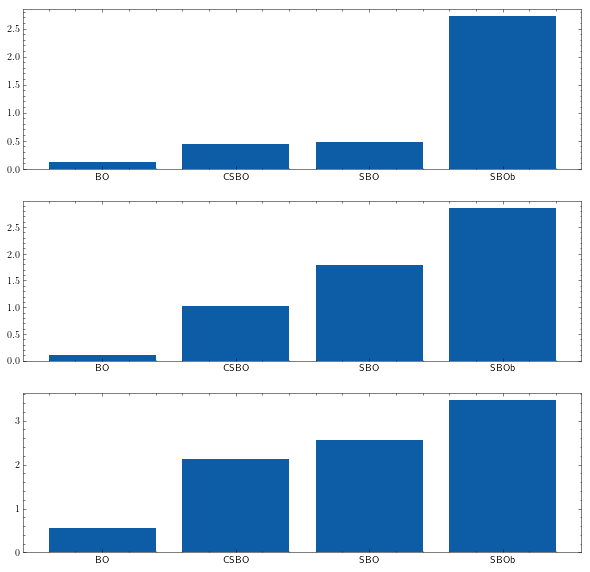

In [103]:
with plt.style.context('science'):
    fig,axes=plt.subplots(len(eval_df.index.levels[0]),figsize=(10,10))
    for i,ax in enumerate(axes.flatten()):
        df=eval_df.loc[eval_df.index.levels[0][i]]
        ax.bar(df.index,df.mae)

plt.show()

# GP evaluation

In [8]:
gps_b2=get_data('sim_data_312_winter_rp0_qf_55_model/CSBO_loglike3_b1__2022_03_13_0440')
gps_b05=get_data('sim_data_312_winter_rp0_qf_55_model/CSBO_loglike3_b0.5__2022_03_13_0438')
bounds = [(0., 4.),(-1,1)]
parameter_set = safeopt.linearly_spaced_combinations(bounds, 100) 
opt=safeopt.SafeOpt(gps_b2[1],parameter_set,fmin=0,num_contexts=1)
optperf=safeopt.SafeOpt(gps_b2[0],parameter_set,fmin=-np.inf,num_contexts=1)
optb05=safeopt.SafeOpt(gps_b05[1],parameter_set,fmin=0,num_contexts=1)
optperfb05=safeopt.SafeOpt(gps_b05[0],parameter_set,fmin=-np.inf,num_contexts=1)

This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning


3 3 1
context_fixed_inputs:  [(2, 0.0)]
3 3 1
context_fixed_inputs:  [(2, 0.5)]
3 3 1
context_fixed_inputs:  [(2, 0.0)]
3 3 1
context_fixed_inputs:  [(2, 0.0)]
3 3 1
context_fixed_inputs:  [(2, 0.5)]
3 3 1
context_fixed_inputs:  [(2, 0.0)]


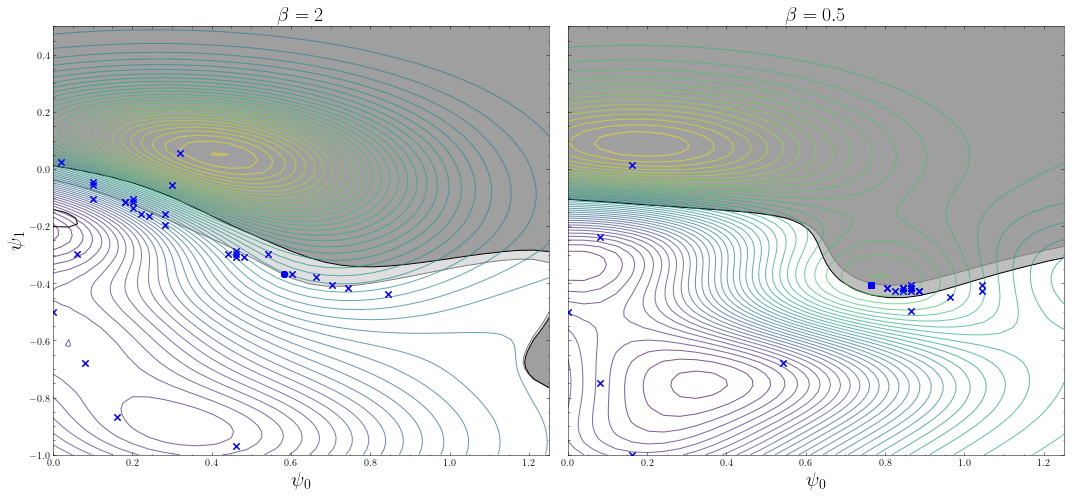

In [9]:
with plt.style.context('science'):
    fig,ax=plt.subplots(1,2,figsize=(15,7),sharey=True)
    opt.context=[[0]]
    opt.plot(100,levels=[-1,0,1],figure=fig,axis=ax[0], colors='grey',colorbar=False)
    opt.context=[[0.5]]
    opt.plot(100,levels=[-1,0,1],figure=fig,axis=ax[0],colors='black',colorbar=False)
    optperf.plot(100,levels=50,figure=fig,axis=ax[0],colorbar=False,alpha=0.7)
    
    optb05.context=[[0]]
    optb05.plot(100,levels=[-1,0,1],figure=fig,axis=ax[1], colors='grey',colorbar=False)
    optb05.context=[[0.5]]
    optb05.plot(100,levels=[-1,0,1],figure=fig,axis=ax[1],colors='black',colorbar=False)
    optperfb05.plot(100,levels=50,figure=fig,axis=ax[1],colorbar=False,alpha=0.7)
    plt.rcParams.update({'font.size': 16})    
    ax[0].set_ylim([-1,0.5])
    ax[1].set_ylim([-1,0.5])
    ax[0].set_xlim([0,1.25])
    ax[1].set_xlim([0,1.25])    
    ax[0].set_xlabel('$\psi_{0}$',fontsize=20)
    ax[0].set_ylabel('$\psi_{1}$',fontsize=20)    
    ax[1].set_xlabel('$\psi_{0}$',fontsize=20)
    ax[0].set_title(r'$\beta=2$',fontsize=20)
    ax[1].set_title(r'$\beta=0.5$',fontsize=20)
plt.tight_layout()    
plt.savefig('qf_const_ctxt_loglike3.pdf')    
plt.show()

In [6]:
gps_b1=get_data('sim_data_312_winter_rp0_qf_55_qs_32_model/CSBO_loglike4_b2__2022_03_15_0838')
gps_b05=get_data('sim_data_312_winter_rp0_qf_55_qs_32_model/CSBO_loglike4_b2__2022_03_15_0838')
bounds = [(0., 4.),(-1,1)]
parameter_set = safeopt.linearly_spaced_combinations(bounds, 100) 

optperf=safeopt.SafeOpt(gps_b1[0],parameter_set,fmin=-np.inf,num_contexts=1)
opt=safeopt.SafeOpt(gps_b1[1],parameter_set,fmin=0,num_contexts=1)
optsf=safeopt.SafeOpt(gps_b1[2],parameter_set,fmin=0,num_contexts=1)
# optb05=safeopt.SafeOpt(gps_b05[1],parameter_set,fmin=0,num_contexts=1)
# optperfb05=safeopt.SafeOpt(gps_b05[0],parameter_set,fmin=-np.inf,num_contexts=1)

with plt.style.context('science'):
    fig,ax=plt.subplots(1,2,figsize=(15,7),sharey=True)
    opt.context=[[0]]
    opt.plot(100,levels=[-1,0,1],figure=fig,axis=ax[0], colors='grey',colorbar=False)
    opt.context=[[0.4]]
    opt.plot(100,levels=[-1,0,1],figure=fig,axis=ax[0],colors='black',colorbar=False)
    optperf.plot(100,levels=50,figure=fig,axis=ax[0],colorbar=False,alpha=0.7)
   

    optsf.context=[[0]]
    optsf.plot(100,levels=[-1,0,1],figure=fig,axis=ax[1], colors='grey',colorbar=False)
    optsf.context=[[0.4]]
    optsf.plot(100,levels=[-1,0,1],figure=fig,axis=ax[1],colors='black',colorbar=False)
    optperf.plot(100,levels=50,figure=fig,axis=ax[1],colorbar=False,alpha=0.7)
    plt.rcParams.update({'font.size': 16})    
    ax[0].set_ylim([-1,0.5])
    ax[1].set_ylim([-1,0.5])
    ax[0].set_xlim([0,1.25])
    ax[1].set_xlim([0,1.25])    
    ax[0].set_xlabel('$\psi_{0}$',fontsize=20)
    ax[0].set_ylabel('$\psi_{1}$',fontsize=20)    
    ax[1].set_xlabel('$\psi_{0}$',fontsize=20)
    ax[0].set_title(r'$q_f$',fontsize=20)
    ax[1].set_title(r'$q_s$',fontsize=20)
plt.tight_layout()
plt.savefig('qfqs_const_ctxt_loglike4.pdf')    
plt.show()

This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning


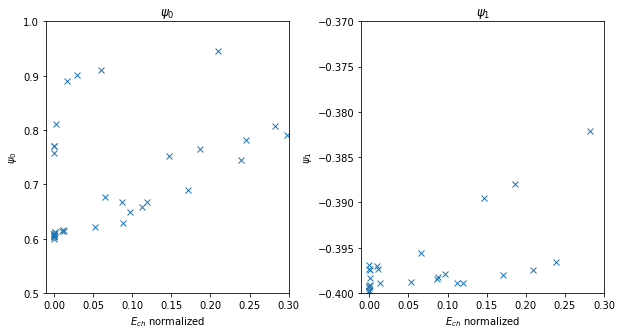

In [175]:
rnd_opt_cst=get_data('NL_opt/rnd_opt_cst_winter_3_1_2_2022_03_02_0252.npy')
rnd_opt_par=get_data('NL_opt/rnd_opt_par_winter_3_1_2_2022_03_02_0252.npy')
e_ch=get_data('sim_data_312_winter_rp0_qf_55/ech_winter_2022_03_08_0707.npy')
# rnd_opt_par=rnd_opt_par[~np.isnan(rnd_opt_par)]

fig,ax=plt.subplots(1,2,figsize=(10,5))
with plt.style.context('science'):
    ax[0].plot(e_ch[:len(rnd_opt_par)],rnd_opt_par[:,0],'x')
    ax[1].plot(e_ch[:len(rnd_opt_par)],rnd_opt_par[:,1],'x')
    ax[0].set_xlim([-0.01,0.3])
    ax[1].set_xlim([-0.01,0.3])
    ax[0].set_ylim([0.5,1])
    ax[1].set_ylim([-0.4,-0.37])
    ax[0].set_title(r'$\psi_0$')
    ax[0].set_xlabel(r'$E_{ch}$ normalized')
    ax[0].set_ylabel(r'$\psi_{0}$')    
    ax[1].set_xlabel(r'$E_{ch}$ normalized')
    ax[1].set_ylabel(r'$\psi_{1}$')
    ax[1].set_title(r'$\psi_1$')
plt.subplots_adjust(wspace=0.3)
plt.savefig('../fig_scripts/par_ech_corr_winter.png')

In [167]:
gps=get_data('sim_data_312_winter_rp0_qf_55/CSBO_loglike1_b05__2022_03_08_0421')
bounds = [(0., 4.),(-1,1)]
parameter_set = safeopt.linearly_spaced_combinations(bounds, 100) 
opt=safeopt.SafeOpt(gps,parameter_set,fmin=[-np.inf,0],num_contexts=1)


This is local package in rbc-parameter-tuning
